## Imports & Downloads

In [1]:
import json, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm
from tqdm.auto import tqdm
from IPython.display import clear_output, HTML, display_html

import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score

In [2]:
!git clone https://github.com/uhh-lt/TextGraphs17-shared-task.git

Cloning into 'TextGraphs17-shared-task'...
remote: Enumerating objects: 498, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 498 (delta 7), reused 14 (delta 4), pack-reused 480
Receiving objects: 100% (498/498), 37.10 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [4]:
data_train = pd.read_csv('TextGraphs17-shared-task/data/tsv/train.tsv', sep='\t')
data_train.head(3)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph
0,0,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
1,1,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q417..."
2,2,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini,Office of the Supreme Leader of Iran,Q38823,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."


In [5]:
data_test = pd.read_csv('TextGraphs17-shared-task/data/tsv/test.tsv', sep='\t')
data_test.head(3)

,sample_id,question,questionEntity,answerEntity,questionEntityId,answerEntityId,graph
0,0,"After publishing A Time to Kill, which book di...",A Time to Kill,A Clash of Kings,Q1213715,Q300370,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30'..."
1,1,"After publishing A Time to Kill, which book di...",A Time to Kill,A Feast for Crows,Q1213715,Q1764445,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30'..."
2,2,"After publishing A Time to Kill, which book di...",A Time to Kill,Fear and Loathing in Las Vegas,Q1213715,Q772435,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30'..."


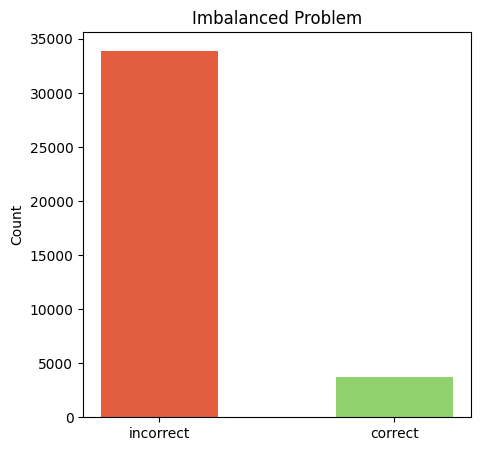

In [6]:
value_counts = data_train['correct'].value_counts()

plt.figure(figsize=(5, 5))
plt.bar(value_counts.index, value_counts.values, width=0.5, color=['#E25E3E', '#90D26D'])
plt.ylabel('Count')
plt.title('Imbalanced Problem')
plt.xticks(value_counts.index, ['incorrect', 'correct'])
plt.show()

In [7]:
N = len(set(data_train['questionEntity']) & set(data_test['questionEntity']))
train = len(set(data_train['questionEntity']))
test = len(set(data_test['questionEntity']))

f'Intersection is {N}, while train_len = {train} and test_len = {test}'

'Intersection is 173, while train_len = 2366 and test_len = 815'

## Distil-BERT Models for Classification
In this notebook we use **Distil-Bert**

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
X = data_train['question'] + ' ' + data_train['answerEntity']
y = data_train['correct'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
max_length = 0
for text in tqdm(X_train):
    tokenized_text = tokenizer(text, return_tensors='pt')
    input_ids = tokenized_text['input_ids']
    if input_ids.shape[1] > max_length:
        max_length = input_ids.shape[1]

print("\nMaximum tokenized text length:", max_length)

  0%|          | 0/30137 [00:00<?, ?it/s]


Maximum tokenized text length: 89


In [22]:
class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer=tokenizer, max_length=max_length):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [23]:
BATCH_SIZE = 4
max_length = 100

train_dataset = BertDataset(X_train, y_train, max_length=max_length)
test_dataset = BertDataset(X_test, y_test, max_length=max_length)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Model

In [63]:
class CustomDistilBERT(nn.Module):
    def __init__(self):
        super(CustomDistilBERT, self).__init__()
        self.distilbert = AutoModel.from_pretrained("distilbert-base-uncased")
        self.hidden_size = self.distilbert.config.hidden_size
        self.linear1 = nn.Linear(self.hidden_size, self.hidden_size * 4)
        self.linear2 = nn.Linear(self.hidden_size * 4, 1)
        self.activ = nn.ReLU()

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Take the [CLS] token representation
        logits = self.linear2(self.activ(self.linear1(pooled_output)))
        return logits.squeeze(-1)

In [64]:
distilbert_model = CustomDistilBERT().to(device)

### Training

In [65]:
def plot_train_process(epoch, losses, metrics, metric_labels=['accuracy', 'f1-score', 'recall', 'average precision']):
    clear_output(True)
    epochs = [i for i in range(1, epoch + 1)]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title('Loss')
    axes[0].plot(epochs, losses[:, 0], label='train loss', marker='o')
    axes[0].plot(epochs, losses[:, 1], label='test loss', marker='o')
    axes[0].set_xlabel('epoch, N')
    axes[0].set_ylabel('loss value')
    axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axes[0].legend()
    axes[1].set_title(f'metrics')
    for idx in range(len(metrics[0])):
        axes[1].plot(epochs, metrics[:, idx], marker='o', label=metric_labels[idx])
    axes[1].set_xlabel('epoch, N')
    axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axes[1].set_ylabel('metrics')
    axes[1].legend(loc='center right')
    plt.show()


def compute_metrics(trues, preds):
    m_preds = [1 if pred > 0.5 else 0 for pred in preds]
    return accuracy_score(trues, m_preds), f1_score(trues, m_preds), recall_score(trues, m_preds), average_precision_score(trues, m_preds)

In [72]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()
        optimizer.zero_grad()
        preds = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)


@torch.no_grad()
def test_model(model, test_loader, criterion):
    model.eval()
    epoch_loss = 0
    true_labels, pred_labels = [], []
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()
        preds = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(preds, labels)
        epoch_loss += loss.item()
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
    return epoch_loss / len(test_loader), true_labels, pred_labels

In [73]:
N_EPOCHS = 100
LEARNING_RATE = 1e-5

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(distilbert_model.parameters(), lr=LEARNING_RATE)

In [ ]:
N_EPOCHS = 10
metrics, losses = [], []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = train_model(distilbert_model, train_loader, optimizer, criterion)
    test_loss, trues, preds = test_model(distilbert_model, test_loader, criterion)
    acc, f1, R, av_precision = compute_metrics(trues, preds)
    metrics.append([acc, f1, R, av_precision])
    losses.append([train_loss, test_loss])
    plot_train_process(epoch, np.array(losses), np.array(metrics))
    print(f'Epoch: {epoch}, Train Loss: {np.array(losses)[:, 0][epoch-1]:.4f}, Test Loss: {np.array(losses)[:, 1][epoch-1]:.4f}, Acc={acc:.2f}, F1={f1:.2f}, Recall={R:.2f}, Average Precision={av_precision:.2f}')

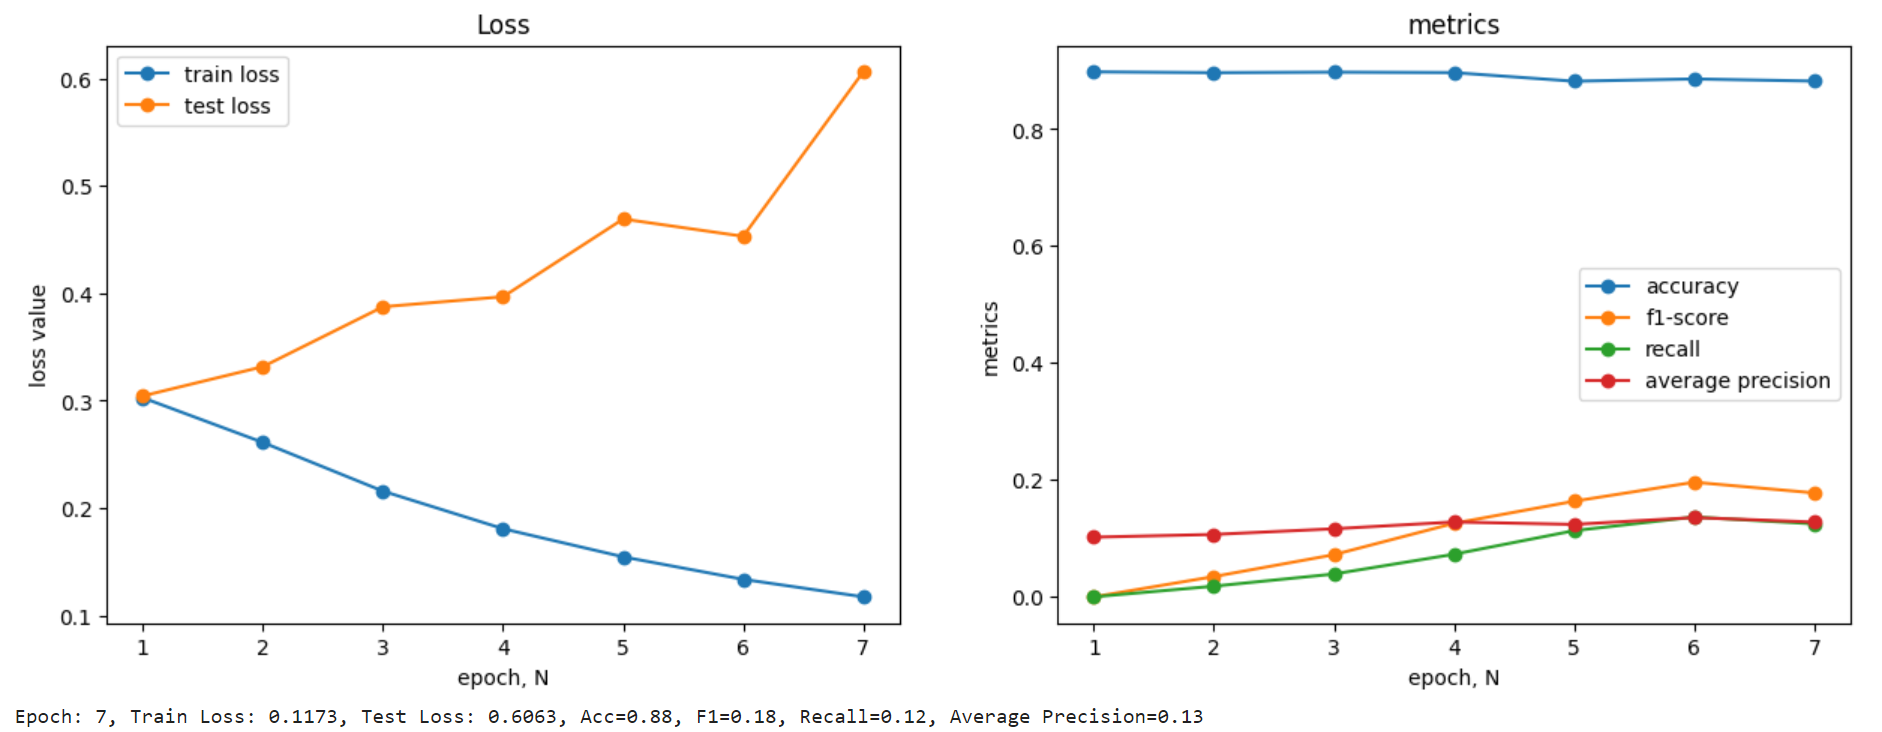

### Save model

In [75]:
save_dir = "drive/MyDrive/Deep Learning NLP/distil-bert/saved_models/"
os.makedirs(save_dir, exist_ok=True)

model_save_path = os.path.join(save_dir, f"distilBERT-model.pt")
torch.save({
    'epoch': epoch,
    'model_state_dict': distilbert_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)

## Inference

In [ ]:
model_save_path = 'drive/MyDrive/Deep Learning NLP/distil-bert/saved_models/distilBERT-model.pt'

checkpoint = torch.load(model_save_path, map_location=torch.device('cpu'))
distilbert_model.load_state_dict(checkpoint['model_state_dict'])
distilbert_model.eval()

In [82]:
data_test['correct'] = False

In [87]:
j = 0
for question in tqdm(data_test['question'].unique()):
    lines = data_test[data_test['question'] == question]

    candidates = torch.zeros(len(lines['answerEntity']))
    for i, answer in enumerate(lines['answerEntity']):
        candidate = question + ' ' + answer
        tokenized_text = tokenizer(candidate)

        with torch.no_grad():
          input = torch.tensor(tokenized_text['input_ids']).unsqueeze(0)
          output = distilbert_model(input.to(device))

        candidates[i] = output.item()

    right_answer = list(lines['answerEntity'])[torch.argmax(candidates).item()]
    data_test.loc[(data_test['question'] == question) & (data_test['answerEntity'] == right_answer), 'correct'] = True
    if j < 5:
      print(question + ' ' + right_answer)
      j += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

After publishing A Time to Kill, which book did its author begin working on immediately? The Firm
Among the European Union countries, which one has the largest land area? Italy
Among the Final Fantasy games, which installment achieved the highest worldwide sales? Final Fantasy XIII
At which Academy Awards was the Leonardo DiCaprio nominated for the first time? Academy Award for Best Actor
Between Ulysses S Grant and Abe Lincoln, which one was president first? Abraham Lincoln


In [88]:
data_test.head(3)

,sample_id,question,questionEntity,answerEntity,questionEntityId,answerEntityId,graph,correct,prediction
0,0,"After publishing A Time to Kill, which book di...",A Time to Kill,A Clash of Kings,Q1213715,Q300370,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30'...",False,0
1,1,"After publishing A Time to Kill, which book di...",A Time to Kill,A Feast for Crows,Q1213715,Q1764445,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30'...",False,0
2,2,"After publishing A Time to Kill, which book di...",A Time to Kill,Fear and Loathing in Las Vegas,Q1213715,Q772435,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30'...",False,0


### Saving Results

In [89]:
data_test['prediction'] = data_test['correct'].astype(int)

In [90]:
test_pred_path = "test_result.tsv"
data_test[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)